## Modelo de recomendação Amazon Fashion

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import numpy as np
import sklearn as sklearn

pd.set_option('float_format', '{:f}'.format)

reviews = pd.read_json('Automotive_5.json', lines = True)

display(reviews.head(15))

# reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
# asin - ID of the product, e.g. 0000013714
# reviewerName - name of the reviewer
# vote - helpful votes of the review
# style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
# reviewText - text of the review
# overall - rating of the product
# summary - summary of the review
# unixReviewTime - time of the review (unix time)
# reviewTime - time of the review (raw)
# image - images that users post after they have received the product

In [ ]:
reviews.shape

(1711519, 12)

In [ ]:
print('Colunas com valores null: \n',reviews.isnull().sum())

Colunas com valores null: 
 overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style             1118104
reviewerName          140
reviewText            866
summary               342
unixReviewTime          0
vote              1520651
image             1668825
dtype: int64


In [ ]:
reviews.describe()

,overall,unixReviewTime
count,1711519.000000,1711519.000000
mean,4.459656,1454262583.608596
std,1.055129,49138282.476421
min,1.000000,968889600.000000
25%,4.000000,1424908800.000000
50%,5.000000,1460678400.000000
75%,5.000000,1490659200.000000
max,5.000000,1538524800.000000


In [ ]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711519 entries, 0 to 1711518
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   overall         int64 
 1   verified        bool  
 2   reviewTime      object
 3   reviewerID      object
 4   asin            object
 5   style           object
 6   reviewerName    object
 7   reviewText      object
 8   summary         object
 9   unixReviewTime  int64 
 10  vote            object
 11  image           object
dtypes: bool(1), int64(2), object(9)
memory usage: 145.3+ MB


#### vendo informacoes de total de usuarios, produtos

In [ ]:
print('usuarios: ', reviews['reviewerID'].nunique())
print('produtos: ', reviews['asin'].nunique())

usuarios:  193651
produtos:  79437


#### tirando informacoes que nao vao ser uteis

In [ ]:
reviews.drop(['reviewerName', 'reviewTime', 'unixReviewTime', 'style', 'verified', 'image' ], axis=1, inplace=True)

#### destribuição de avaliações por produto

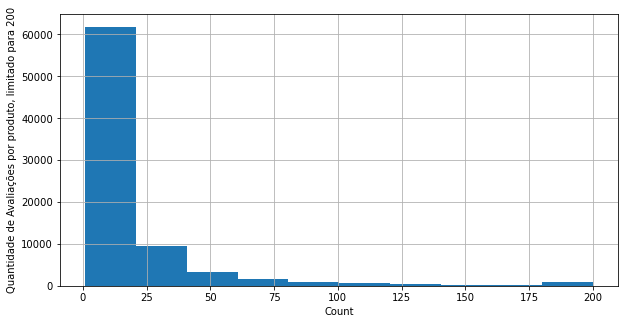

In [ ]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import math

distribution = reviews.groupby('asin')['overall'].count().clip(upper=200)
distribution.hist(figsize=(10,5))
plt.ylabel("Quantidade de Avaliações por produto, limitado para 200")
plt.xlabel("Count")
plt.show()

#### pegando a media da avaliacao e a quantidade de vezes que cada produto aparece

##### vamos usar esse dfMerged para juntar todos os reviews de cada produto, assim podemos identificar todas as palavras do review de cada produto (isso ta mais na frente no KNN)

In [ ]:
count = reviews.groupby("asin", as_index=False).count()
mean = reviews.groupby("asin", as_index=False).mean()

dfMerged = pd.merge(reviews, count, how='right', on=['asin'])
dfMerged = pd.merge(dfMerged, mean, how='right', on=['asin'])
dfMerged


,overall_x,reviewerID_x,asin,reviewText_x,summary_x,vote_x,overall_y,reviewerID_y,reviewText_y,summary_y,vote_y,overall
0,4,A8WEXFRWX1ZHH,0209688726,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,NaN,71,71,71,71,11,4.042254
1,1,ABCA1A8E4DGV1,0209688726,It sucks barely picks up anything definitely n...,sucks,NaN,71,71,71,71,11,4.042254
2,1,A1NX8HM89FRQ32,0209688726,"Well to write a short one, it blew 2 fuses of ...",Defective,NaN,71,71,71,71,11,4.042254
3,3,A1X77G023NY0KY,0209688726,I have absolutely no memory of buying this but...,Looks cool! Probably works,NaN,71,71,71,71,11,4.042254
4,5,A3GK37JO2MGW6Q,0209688726,it ok it does it job,Five Stars,NaN,71,71,71,71,11,4.042254
...,...,...,...,...,...,...,...,...,...,...,...,...
1711514,5,A73IGP6LB5WDM,B01HJI17Y8,"A breeze to install, and brighter that OEM. Do...",An improvement.,NaN,8,8,8,8,0,4.500000
1711515,1,A261FYJ5MTGSUJ,B01HJI17Y8,"They're not that bright, my regular halogen ar...",One Star,NaN,8,8,8,8,0,4.500000
1711516,5,A1PSKAPFER6BZW,B01HJI17Y8,Wow! So bright. I can see so much farther. Lig...,Drastically improves night vision.,NaN,8,8,8,8,0,4.500000
1711517,5,A1MJUNTX7CTR5U,B01HJI17Y8,Way better than stock. Nice bright and white. ...,"NICE, BRIGHT AND WHITE",NaN,8,8,8,8,0,4.500000


#### Separando apenas o codigo do produto a media da nota e quantidade de reviews, vai ser usado no SVD

In [ ]:
data = dfMerged[['asin', 'overall', 'reviewerID_y', 'summary_x']]

data = data.rename(columns={'reviewerID_y': 'reviewsCount', 'summary_x': 'summary', 'overall': 'rating'})

data.drop(['summary' ], axis=1, inplace=True)

data = data.drop_duplicates(subset=['asin'], keep='first')

data.reset_index()

data

,asin,rating,reviewsCount
0,0209688726,4.042254,71
71,085696588X,4.750000,8
79,0857339583,4.583333,12
91,0983270139,4.666667,6
97,0983270163,5.000000,6
...,...,...,...
1711451,B01HJ85Q3Q,4.676471,34
1711485,B01HJCWQPS,3.200000,5
1711490,B01HJFDJ8S,4.307692,13
1711503,B01HJGNOV4,4.625000,8


#### Distribuição das avaliações 

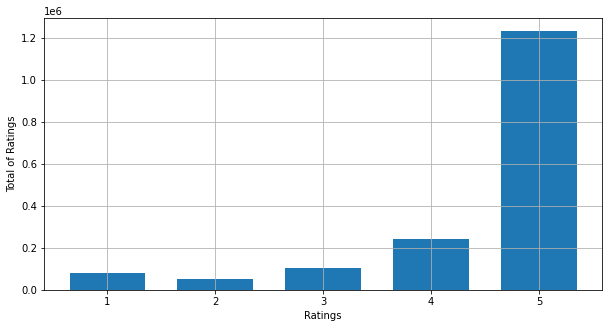

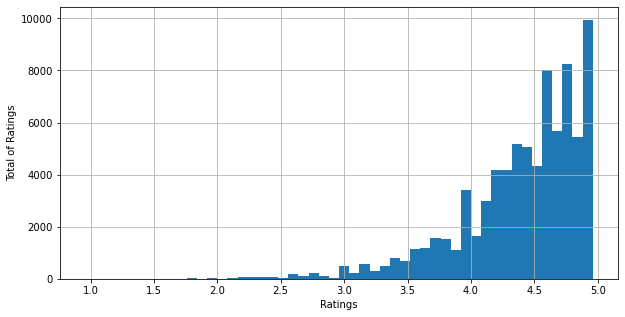

In [ ]:
# antes do merge
reviews['overall'].hist(bins=range(1,7), figsize=(10,5),  align='left', rwidth=0.7)
plt.ylabel("Total of Ratings")
plt.xlabel("Ratings")
plt.show()


# depois do merge
data['rating'].hist(bins=50, figsize=(10,5),  align='left')
plt.ylabel("Total of Ratings")
plt.xlabel("Ratings")
plt.show()

#### Existem varios metodos de recomendacao popularidade, nota, similaridade, etc entao vamos selecionar algumas e analisar

#### 1. Utilizando SVD para analise

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(reviews[['reviewerID', 'asin', 'overall']], test_size=0.25)
print("train size: ", train_data.shape)
print("test size: ", test_data.shape)

train size:  (1283639, 3)
test size:  (427880, 3)


#### Utilizando a biblioteca scikit-surprise

In [ ]:
# pip install scikit-surprise
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise import SVD
from surprise.model_selection import cross_validate

algo = SVD()
reader = Reader(rating_scale=(1, 5))

data_train = Dataset.load_from_df(train_data, reader=reader)
data_test = Dataset.load_from_df(test_data, reader=reader)

# dataset = Dataset.load_from_df(data, reader=reader)
# cross_validate(algo, dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

#### Comparando os valores do train e test

In [ ]:
mean = data_train.global_mean
print('Train rating', mean)

Train rating 4.458614143072936


In [ ]:
mean = data_test.global_mean
print('Test rating', mean)

Test rating 4.462781621015238


In [ ]:
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [ ]:
algo = SVD(n_factors=5)
algo.fit(data_train)

#### RMSE do train e test

In [ ]:
train_pred = algo.test(data_trainset)
accuracy.rmse(train_pred)

RMSE: 0.8585


0.8585332930470158

In [ ]:
test_pred = algo.test(data_testset)
accuracy.mse(test_pred)

MSE: 0.9368


0.9367803107582499

In [ ]:
# uid = user id
# iid = item id
# r_ui = rating
predict = algo.predict(uid=reviews['reviewerID'][0], iid=reviews['asin'][0], r_ui=reviews['overall'][0], verbose = True)

user: A8WEXFRWX1ZHH item: 0209688726 r_ui = 4.00   est = 3.76   {'was_impossible': False}


#### 2. KNN - Utilizando palavras para recomendacao

#### tratando os textos para depois realizar o knn

In [ ]:
dfMerged

dfNew = dfMerged[['asin','summary_x','overall',"overall_y"]]
dfNew = dfNew.rename(columns={'overall_y': 'reviewsCount', 'summary_x': 'summary', 'overall': 'rating'})

# selecionado apenas acima de 100 reviews
dfNew = dfNew[dfNew.reviewsCount >= 100]

dfNew

,asin,summary,rating,reviewsCount
1469,B00004Y774,Top quality as always,4.344538,119
1470,B00004Y774,Works pretty good,4.344538,119
1471,B00004Y774,"For smaller size surfaces, this is fine",4.344538,119
1472,B00004Y774,Another piece of [stuff] from Porter-Cable,4.344538,119
1473,B00004Y774,Four Stars,4.344538,119
...,...,...,...,...
1710206,B01HB1OYUC,Feel the quality,4.653465,101
1710207,B01HB1OYUC,Used to repair a passenger car tire,4.653465,101
1710208,B01HB1OYUC,Five Stars,4.653465,101
1710209,B01HB1OYUC,The best tools! You can depend not to let you ...,4.653465,101


In [ ]:
dfProductReview = reviews.groupby("asin", as_index=False).mean()
ProductReviewSummary = dfNew.groupby("asin")["summary"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)

ProductReviewSummary

,summary
asin,
B00004Y774,"[Top quality as always, Works pretty good, For..."
B00004YK76,"[Can't do the job without it!, Four Stars, Fiv..."
B00008RW9U,"[Works for light dust, but is really only the ..."
B00008RW9V,"[What did I ever do before these?, Best you ca..."
B0000AXDFT,"[Adequate, Five Stars, Inexpensive car cover.,..."
...,...
B01H2XD2DY,[got it for my crap machine & other thing if n...
B01H46MXO8,"[Perfect fit, Five Stars, Fits many jack pads,..."
B01H8VILDQ,"[Great light output, Five Stars, Much brighter..."


In [ ]:
dfProductReview = pd.merge(ProductReviewSummary, dfProductReview, on="asin", how='inner')

dfProductReview 

,asin,summary,overall
0,B00004Y774,"[Top quality as always, Works pretty good, For...",4.344538
1,B00004YK76,"[Can't do the job without it!, Four Stars, Fiv...",4.552381
2,B00008RW9U,"[Works for light dust, but is really only the ...",4.483660
3,B00008RW9V,"[What did I ever do before these?, Best you ca...",4.522989
4,B0000AXDFT,"[Adequate, Five Stars, Inexpensive car cover.,...",3.885827
...,...,...,...
2417,B01H2XD2DY,[got it for my crap machine & other thing if n...,4.515625
2418,B01H46MXO8,"[Perfect fit, Five Stars, Fits many jack pads,...",4.500000
2419,B01H8VILDQ,"[Great light output, Five Stars, Much brighter...",4.311377
2420,B01HAWMBH0,"[Correct fit, good value, Easy, effective, gre...",4.810127


#### Limpando texto

In [ ]:
import re
def cleanReviews(reviewList):
    reviewsText = ''
    for review in reviewList:
        if not type(review) == str:
            continue
        r= re.sub(r'[^a-zA-Z ]', '', review)
        r = r.lower()
        reviewsText += r + ' '
    return reviewsText[:len(reviewsText)-1]

In [ ]:
dfProductReview["summaryAll"] = dfProductReview["summary"].apply(cleanReviews)
dfProductReview = dfProductReview.drop_duplicates(['overall'], keep='last')
dfProductReview = dfProductReview.reset_index()

dfProductReview

,index,asin,summary,overall,summaryAll
0,0,B00004Y774,"[Top quality as always, Works pretty good, For...",4.344538,top quality as always works pretty good for sm...
1,2,B00008RW9U,"[Works for light dust, but is really only the ...",4.483660,works for light dust but is really only the fi...
2,3,B00008RW9V,"[What did I ever do before these?, Best you ca...",4.522989,what did i ever do before these best you can b...
3,4,B0000AXDFT,"[Adequate, Five Stars, Inexpensive car cover.,...",3.885827,adequate five stars inexpensive car cover nice...
4,5,B0000AXNMO,"[great for windshields, have been a big fan fo...",4.644366,great for windshields have been a big fan for ...
...,...,...,...,...,...
2089,2417,B01H2XD2DY,[got it for my crap machine & other thing if n...,4.515625,got it for my crap machine other thing if nee...
2090,2418,B01H46MXO8,"[Perfect fit, Five Stars, Fits many jack pads,...",4.500000,perfect fit five stars fits many jack pads per...
2091,2419,B01H8VILDQ,"[Great light output, Five Stars, Much brighter...",4.311377,great light output five stars much brighter th...
2092,2420,B01HAWMBH0,"[Correct fit, good value, Easy, effective, gre...",4.810127,correct fit good value easy effective great va...


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from pandas import DataFrame 

allReviews = dfProductReview["summaryAll"] 
# utilizando countVector do sklearn para transformar as palavras em vetores, selecionando apenas as 500 palavras mais frequentes
countVector = CountVectorizer(max_features = 500, stop_words='english') 
transformedReviews = countVector.fit_transform(allReviews) 
dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names_out())
dfReviews = dfReviews.astype(int)

dfReviews

,absolutely,ac,accessory,accord,accurate,actually,adapter,add,addition,advertised,...,wow,wrangler,wrench,wrong,year,years,yellow,yes,youll,youre
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,3,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,3,2,0,1,0,0
4,0,0,0,0,0,0,0,1,0,2,...,1,0,0,0,0,2,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,0,4,0,0,0,1,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
2090,0,0,2,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
2091,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2092,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


#### Criando train test

In [ ]:
train_data, test_data = train_test_split(dfReviews, test_size=0.2)

train_data = train_data.to_numpy()
test_data = test_data.to_numpy()


In [ ]:
from surprise import KNNBasic
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(train_data)
distances, indices = neighbor.kneighbors(train_data)

#### Exemplo de produto relacionado

In [ ]:
vizinhos = neighbor.kneighbors([train_data[0]])
relacionados = vizinhos[1]
prim = relacionados[0][0]

print("Produto: ", dfProductReview["asin"][train_data.shape[0] + 0], "produto mais relacionado: ",dfProductReview["asin"][prim])


Produto:  B00JN0U4SQ produto mais relacionado:  B00004Y774


#### predição do rating do produto

In [ ]:
train_target, test_target = train_test_split(dfProductReview['overall'], test_size=0.2)
# colocando os valores de train e test como inteiros pois o rating é inteiro
train_target = train_target.astype(int)
test_target = test_target.astype(int)

knn = neighbors.KNeighborsClassifier(3, weights='distance')
knn.fit(train_data, train_target)
knnpredict = knn.predict(test_data)

print(classification_report(test_target, knnpredict))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00        23
           4       0.94      0.98      0.96       396

    accuracy                           0.93       419
   macro avg       0.47      0.49      0.48       419
weighted avg       0.89      0.93      0.91       419



#### Precisão do modelo

In [ ]:
accuracy_score(test_target, knnpredict)

0.9307875894988067

#### MSE do modelo

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_target, knnpredict)

0.06921241050119331

In [ ]:
# kk = 40
# algo = KNNBasic(k = kk, verbose = True)
# cv = cross_validate(algo, datas, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)